In [6]:
#Bibliotecas
import os
import requests
import zipfile
import io
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# URL base
base_url = "https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/mensal/Brasil/"

# Pasta local onde salvar os arquivos
download_dir = "dados_queimadas_mensais"
os.makedirs(download_dir, exist_ok=True)


In [31]:
# Função para baixar e ler CSV direto
def baixar_csv(url):
    filename = os.path.join(download_dir, os.path.basename(url))
    #print(f"[↓] Baixando CSV: {filename}")
    response = requests.get(url)
    response.raise_for_status()
    with open(filename, "wb") as f:
        f.write(response.content)
    return pd.read_csv(filename, encoding="latin1")

# Função para baixar e extrair CSV de um ZIP
def baixar_e_extrair_zip(url):
    #print(f"[↓] Baixando ZIP: {url}")
    response = requests.get(url)
    response.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        dfs = []
        for name in z.namelist():
            if name.endswith(".csv"):
                #print(f"  └─ Lendo {name}")
                with z.open(name) as f:
                    df = pd.read_csv(f, encoding="latin1")
                    dfs.append(df)
        return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [32]:
# Coleta dos links
response = requests.get(base_url)
response.raise_for_status()
soup = BeautifulSoup(response.text, "html.parser")

# Filtra arquivos CSV e ZIP
file_urls = []
for link in soup.find_all("a"):
    href = link.get("href")
    if href and (href.endswith(".csv") or href.endswith(".zip")):
        file_urls.append(urljoin(base_url, href))

#print(f"🔗 Arquivos encontrados: {len(file_urls)}")

# Acumular os dados em um único DataFrame
dados_acumulados = []

for file_url in sorted(file_urls):
    try:
        if file_url.endswith(".csv"):
            df = baixar_csv(file_url)
        elif file_url.endswith(".zip"):
            df = baixar_e_extrair_zip(file_url)
        else:
            continue

        if not df.empty:
            dados_acumulados.append(df)
    except Exception as e:
        print(f"⚠️ Erro ao processar {file_url}: {e}")

# Concatenar tudo em um DataFrame único
df_final = pd.concat(dados_acumulados, ignore_index=True)

# Exibir amostra
print("\n✅ Consolidado final:")
print(df_final.info())
print(df_final.head())


✅ Consolidado final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13085552 entries, 0 to 13085551
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   lat                    float64
 2   lon                    float64
 3   data_hora_gmt          object 
 4   satelite               object 
 5   municipio              object 
 6   estado                 object 
 7   pais                   object 
 8   municipio_id           int64  
 9   estado_id              int64  
 10  pais_id                int64  
 11  numero_dias_sem_chuva  float64
 12  precipitacao           float64
 13  risco_fogo             float64
 14  bioma                  object 
 15  frp                    float64
dtypes: float64(6), int64(3), object(7)
memory usage: 1.6+ GB
None
                                     id       lat       lon  \
0  8c3be1cf-55a4-3d95-9e1d-6edbbb9985c9 -13.25160 -45.55090   
1  61d686ec-fc2f-3c5c-

#  Análise Exploratória de Dados (EDA)
Nesta seção, realizaremos uma análise exploratória de dados (EDA) no conjunto de dados que contém informações sobre incêndios florestais no Brasil. O dataset foi obtido da plataforma TerraBrasilis, que disponibiliza dados abertos sobre queimadas:

https://terrabrasilis.dpi.inpe.br/queimadas/portal/


O conjunto de dados inclui informações detalhadas, como data, hora e localização das ocorrências de incêndios, além de outros atributos relevantes. Esta análise tem como objetivo descobrir padrões, tendências e insights que nos ajudem a entender melhor a dinâmica dos incêndios no Brasil.

In [10]:
df=df_final.copy()

In [11]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13085552 entries, 0 to 13085551
Data columns (total 16 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   id                     13085552 non-null  object 
 1   lat                    13085552 non-null  float64
 2   lon                    13085552 non-null  float64
 3   data_hora_gmt          13085552 non-null  object 
 4   satelite               13085552 non-null  object 
 5   municipio              13085552 non-null  object 
 6   estado                 13085552 non-null  object 
 7   pais                   13085552 non-null  object 
 8   municipio_id           13085552 non-null  int64  
 9   estado_id              13085552 non-null  int64  
 10  pais_id                13085552 non-null  int64  
 11  numero_dias_sem_chuva  12786732 non-null  float64
 12  precipitacao           12786732 non-null  float64
 13  risco_fogo             12786732 non-null  float64
 14  

In [12]:
df.describe(include='all')

,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
count,13085552,1.308555e+07,1.308555e+07,13085552,13085552,13085552,13085552,13085552,1.308555e+07,1.308555e+07,13085552.0,1.278673e+07,1.278673e+07,1.278673e+07,13085544,1.260422e+07
unique,13085552,NaN,NaN,1015970,17,5278,27,1,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
top,c2a1ced1-397f-3f4c-a915-b60c1288c530,NaN,NaN,2024-09-06 04:57:00,NOAA-20,ALTAMIRA,PARÃ,Brasil,NaN,NaN,NaN,NaN,NaN,NaN,AmazÃ´nia,NaN
freq,1,NaN,NaN,14513,3335983,346223,2844245,13085552,NaN,NaN,NaN,NaN,NaN,NaN,6850894,NaN
mean,NaN,-9.714673e+00,-5.270260e+01,NaN,NaN,NaN,NaN,NaN,2.708140e+06,2.701282e+01,33.0,1.871123e+01,6.755843e-01,-9.276793e+00,NaN,3.875775e+01
std,NaN,5.933917e+00,7.190434e+00,NaN,NaN,NaN,NaN,NaN,1.528448e+06,1.527271e+01,0.0,1.082711e+02,3.401928e+00,9.975580e+01,NaN,7.099058e+01
min,NaN,-3.373356e+01,-7.386338e+01,NaN,NaN,NaN,NaN,NaN,1.100015e+06,1.100000e+01,33.0,-9.990000e+02,0.000000e+00,-9.990000e+02,NaN,-3.800000e+00
25%,NaN,-1.321330e+01,-5.749200e+01,NaN,NaN,NaN,NaN,NaN,1.503606e+06,1.500000e+01,33.0,4.000000e+00,0.000000e+00,6.000000e-01,NaN,3.800000e+00
50%,NaN,-8.980770e+00,-5.272523e+01,NaN,NaN,NaN,NaN,NaN,2.103505e+06,2.100000e+01,33.0,1.100000e+01,0.000000e+00,1.000000e+00,NaN,1.020000e+01
75%,NaN,-6.039610e+00,-4.703740e+01,NaN,NaN,NaN,NaN,NaN,5.002159e+06,5.000000e+01,33.0,3.900000e+01,0.000000e+00,1.000000e+00,NaN,5.780000e+01


# Descrição do Conjunto de Dados

Este conjunto de dados fornece informações abrangentes sobre incêndios florestais no Brasil, cobrindo o período de 2023 até maio de 2025. Ele inclui atributos detalhados relacionados à localização, data/hora e características das ocorrências de incêndio. Abaixo está uma visão geral das colunas do dataset:

- **id**: Identificador único para cada registro de incêndio.
- **lat**: Coordenada de latitude da ocorrência do incêndio.
- **lon**: Coordenada de longitude da ocorrência do incêndio.
- **data_hora_gmt**: Data e hora da ocorrência do incêndio em GMT.
- **satelite**: Satélite responsável por detectar o incêndio.
- **municipio**: Município onde o incêndio ocorreu.
- **estado**: Estado onde o incêndio ocorreu.
- **pais**: País da ocorrência do incêndio (todos os registros são do Brasil).
- **municipio_id**: Identificador único do município.
- **estado_id**: Identificador único do estado.
- **pais_id**: Identificador único do país.
- **numero_dias_sem_chuva**: Número de dias consecutivos sem chuva antes da ocorrência do incêndio.
- **precipitacao**: Nível de precipitação (em mm) registrado no momento do incêndio.
- **risco_fogo**: Índice de risco de fogo, indicando a probabilidade de ocorrência de incêndio.
- **bioma**: Bioma onde o incêndio ocorreu.
- **frp**: Potência Radiativa do Fogo (FRP) em megawatts (MW), representando a energia radiante liberada por unidade de tempo, a qual está correlacionada com a taxa de queima da vegetação.

Adicionalmente, as colunas **numero_dias_sem_chuva**, **precipitacao** e **risco_fogo** são atualizadas diariamente ao final de cada dia, garantindo que os dados permaneçam atualizados e precisos.

É possível observar que as colunas **numero_dias_sem_chuva**, **precipitacao**, **risco_fogo** e **frp** possuem valores nulos, indicando que há dados ausentes que não foram atualizados.


## feature engineering
Adicionando algumas feature para auxiliar na análise

In [13]:
# Função para codificação cíclica do dia do ano
def encode_day_of_year_cyclic(day_of_year):
    """
    Codifica o dia do ano (1–366) usando uma transformação cosseno para capturar sua natureza cíclica.

    Esta abordagem é útil porque os dias do ano são cíclicos — o dia 1 e o dia 365 são
    adjacentes temporalmente, mas numericamente distantes. Modelos tradicionais não consideram
    essa relação cíclica. Ao projetar o dia em um círculo unitário usando uma função cosseno,
    preservamos a estrutura sazonal e a continuidade da variável tempo.

    A transformação mapeia cada dia para um ponto em um círculo, onde tempos semelhantes do ano
    produzem valores semelhantes, facilitando para os modelos de aprendizado de máquina
    aprenderem padrões sazonais.

    Parâmetros:
        day_of_year (int): O dia do ano, variando de 1 a 366.

    Retorna:
        float: Valor codificado por cosseno representando a posição cíclica do dia.
    """
    return np.cos(2 * np.pi * day_of_year / 365)


In [14]:
# Função para codificar o dia do ano ciclicamente
def encode_day_of_year_cyclic(day_of_year):
    return np.cos(2 * np.pi * day_of_year / 365)

In [15]:
df['date'] = pd.to_datetime(df['data_hora_gmt'], format="%Y-%m-%d %H:%M:%S")

In [16]:
# Criar novas features de tempo
df["day_of_year"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df["weekday"] = df["date"].dt.weekday
df['year'] = df['date'].dt.year
df["cos_day_of_year"] = encode_day_of_year_cyclic(df["day_of_year"])

In [17]:
# Remover colunas desnecessárias
df = df.drop(['data_hora_gmt', 'pais', 'pais_id'], axis=1)

### **Análise Exploratória dos Dados**


### Risco de Fogo

Existem alguns valores de -999 nos campos de risco_fogo. De acordo com o website Terrabrasilis o atributo "RiscoFogo" dos focos é o valor do Risco de Fogo previsto para o mesmo dia da ocorrência do foco, onde os valores são válidos de 0 a 1 e, o número -999 representa valor inválido, normalmente relacionado como área urbana ou corpos d'água, onde não faz sentido calcular o Riso de Fogo. Desta forma estes dados serão retirados do dataset

In [18]:
df = df[df.risco_fogo>0]

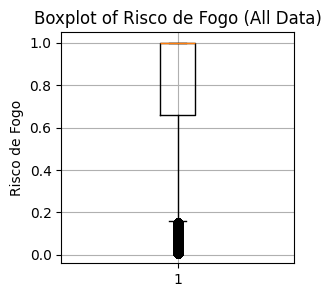

In [19]:
plt.figure(figsize=(3, 3))
plt.boxplot(df['risco_fogo'].dropna())
plt.title('Boxplot of Risco de Fogo (All Data)')
plt.ylabel('Risco de Fogo')
plt.grid(True)
plt.show()


O intervalo interquartil do risco de fogo está entre 0.7 e 1.0 — indicando uma tendência alta de risco, sendo que a mediana está muito próxima de 1. Isto indica que pelo menos metade dos dados representam locais com risco máximo.

Existem alguns valores baixos e outliers, mas são minoria.

Isso sugere que o risco de fogo frequentemente é muito alto nos dados analisados — o que pode estar associado a época do ano, região, ou condições ambientais.

### Datas

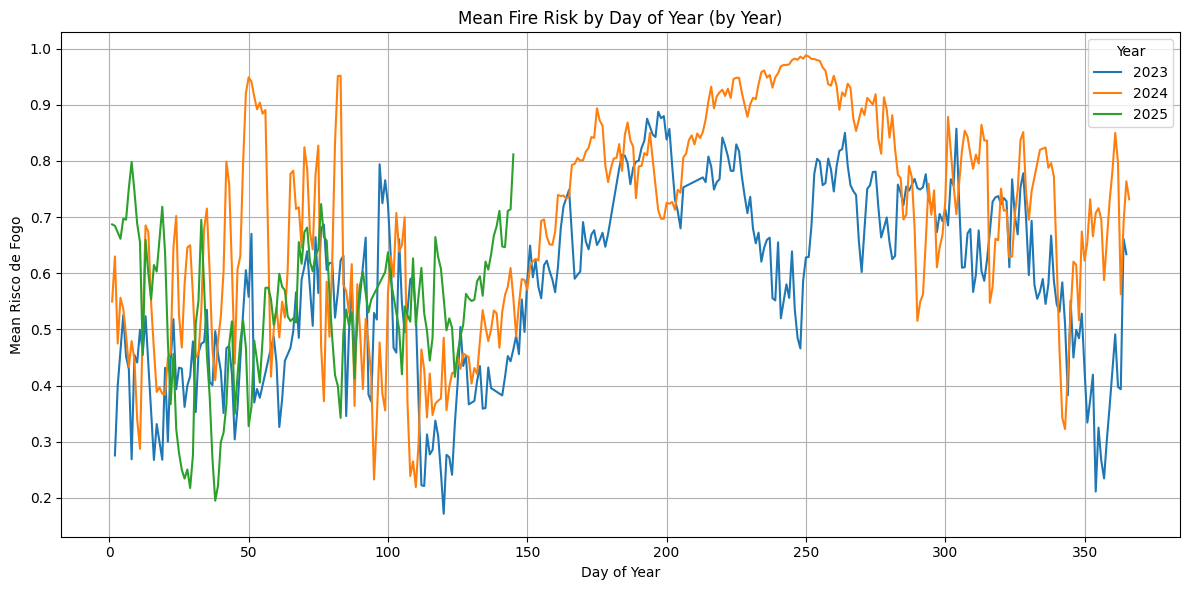

In [20]:

mean_risk_by_year = df.groupby(['year', 'day_of_year'])['risco_fogo'].mean().reset_index()

plt.figure(figsize=(12, 6))
for year in mean_risk_by_year['year'].unique():
    data = mean_risk_by_year[mean_risk_by_year['year'] == year]
    plt.plot(data['day_of_year'], data['risco_fogo'], label=str(year))

plt.title('Mean Fire Risk by Day of Year (by Year)')
plt.xlabel('Day of Year')
plt.ylabel('Mean Risco de Fogo')
plt.grid(True)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


A imagem mostra um gráfico de linha do tempo do risco médio de fogo por ano.
Permite observar padrões sazonais de risco de fogo ao longo do ano. Sendo possível observar um aumento do risco geral a partir do 2 semestre do ano e com queda no final do ano.
É interessante observar que em 2024 ocorreu um aumento do risco com relação ao ano anterior.
2025 conta apenas com dados para o início do ano (até ~dia 130). O risco varia entre 0.3 e 0.7 — similar a outros anos no início do período.

**Conclusões:**
- O gráfico mostra um padrão sazonal claro de aumento do risco de fogo no segundo semestre do ano.

- O ano de 2024 teve picos mais altos e pode ter sido um ano de maior severidade em termos de risco de fogo.




## Biomas

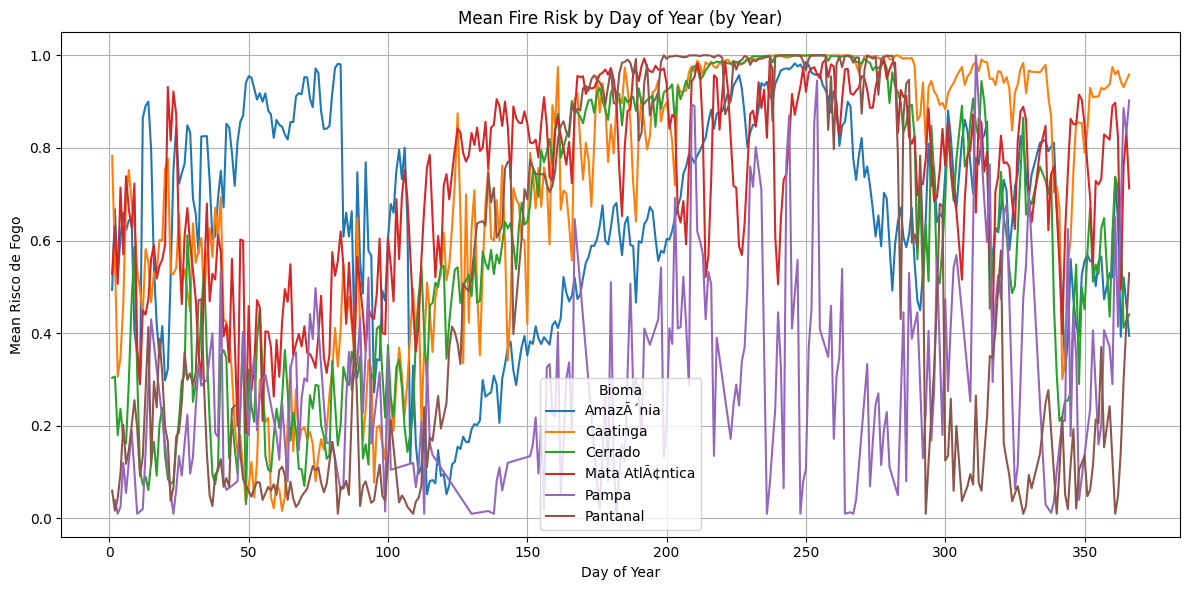

In [21]:

mean_risk_by_bioma = df[df.year==2024].groupby(['bioma', 'day_of_year'])['risco_fogo'].mean().reset_index()

plt.figure(figsize=(12, 6))
for b in mean_risk_by_bioma['bioma'].unique():
    data = mean_risk_by_bioma[mean_risk_by_bioma['bioma'] == b]
    plt.plot(data['day_of_year'], data['risco_fogo'], label=str(b))

plt.title('Mean Fire Risk by Day of Year (by Year)')
plt.xlabel('Day of Year')
plt.ylabel('Mean Risco de Fogo')
plt.grid(True)
plt.legend(title='Bioma')
plt.tight_layout()
plt.show()


Existe um total de  27 estados , 5278 cidades e 6 biomas representados no dataset.


## Verificação de Valores Ausentes

In [22]:
# Verificação de Valores Ausentes
print("\n\n--- Valores Ausentes por Coluna ---")
print(df.isnull().sum())

# Substituir -999.0 (se presente) por NaN nas colunas numéricas relevantes
# e então lidar com eles (ex: preencher com a média ou mediana, ou remover)
# Para 'risco_fogo' e 'numero_dias_sem_chuva', -999.0 parece ser um placeholder para dados ausentes.
# Vamos substituí-los por NaN para que não afetem as análises numéricas.
df.replace(-999.0, np.nan, inplace=True)



--- Valores Ausentes por Coluna ---
id                            0
lat                           0
lon                           0
satelite                      0
municipio                     0
estado                        0
municipio_id                  0
estado_id                     0
numero_dias_sem_chuva         0
precipitacao                  0
risco_fogo                    0
bioma                         1
frp                      452397
date                          0
day_of_year                   0
month                         0
weekday                       0
year                          0
cos_day_of_year               0
dtype: int64


In [23]:
print("\n--- Valores Ausentes após substituição de -999.0 por NaN ---")
print(df.isnull().sum())

# Opcional: Preencher valores ausentes para análises (ex: com a mediana)
# Para 'risco_fogo' e 'numero_dias_sem_chuva', a mediana pode ser uma boa escolha
# se a distribuição não for muito assimétrica.
for col in ['numero_dias_sem_chuva', 'precipitacao', 'risco_fogo', 'frp']:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Valores ausentes em '{col}' preenchidos com a mediana: {median_val:.2f}")

print("\n--- Valores Ausentes após preenchimento ---")
print(df.isnull().sum())


--- Valores Ausentes após substituição de -999.0 por NaN ---
id                            0
lat                           0
lon                           0
satelite                      0
municipio                     0
estado                        0
municipio_id                  0
estado_id                     0
numero_dias_sem_chuva    119515
precipitacao                  0
risco_fogo                    0
bioma                         1
frp                      452397
date                          0
day_of_year                   0
month                         0
weekday                       0
year                          0
cos_day_of_year               0
dtype: int64


<ipython-input-23-a9a6887891d0>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


Valores ausentes em 'numero_dias_sem_chuva' preenchidos com a mediana: 12.00


<ipython-input-23-a9a6887891d0>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


Valores ausentes em 'frp' preenchidos com a mediana: 10.30

--- Valores Ausentes após preenchimento ---
id                       0
lat                      0
lon                      0
satelite                 0
municipio                0
estado                   0
municipio_id             0
estado_id                0
numero_dias_sem_chuva    0
precipitacao             0
risco_fogo               0
bioma                    1
frp                      0
date                     0
day_of_year              0
month                    0
weekday                  0
year                     0
cos_day_of_year          0
dtype: int64


### Mapa de Calor

In [24]:
# Correlação entre variáveis numéricas
print("\n\n--- Matriz de Correlação entre Variáveis Numéricas ---")
# Selecionar apenas colunas numéricas após as transformações
numerical_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols].corr()
print(correlation_matrix)



--- Matriz de Correlação entre Variáveis Numéricas ---
                            lat       lon  municipio_id  estado_id  \
lat                    1.000000 -0.006575     -0.673214  -0.671604   
lon                   -0.006575  1.000000      0.017887   0.015490   
municipio_id          -0.673214  0.017887      1.000000   0.999983   
estado_id             -0.671604  0.015490      0.999983   1.000000   
numero_dias_sem_chuva -0.199695  0.155969      0.265692   0.265029   
precipitacao           0.004570 -0.054714     -0.014089  -0.013977   
risco_fogo            -0.034547  0.236408      0.066575   0.066062   
frp                   -0.031799 -0.018493      0.050563   0.050719   
day_of_year            0.086491  0.118231     -0.076820  -0.076731   
month                  0.080032  0.118393     -0.070960  -0.070875   
weekday                0.038522  0.009836     -0.027620  -0.027591   
year                  -0.104217 -0.091378      0.074158   0.074102   
cos_day_of_year        0.246948  

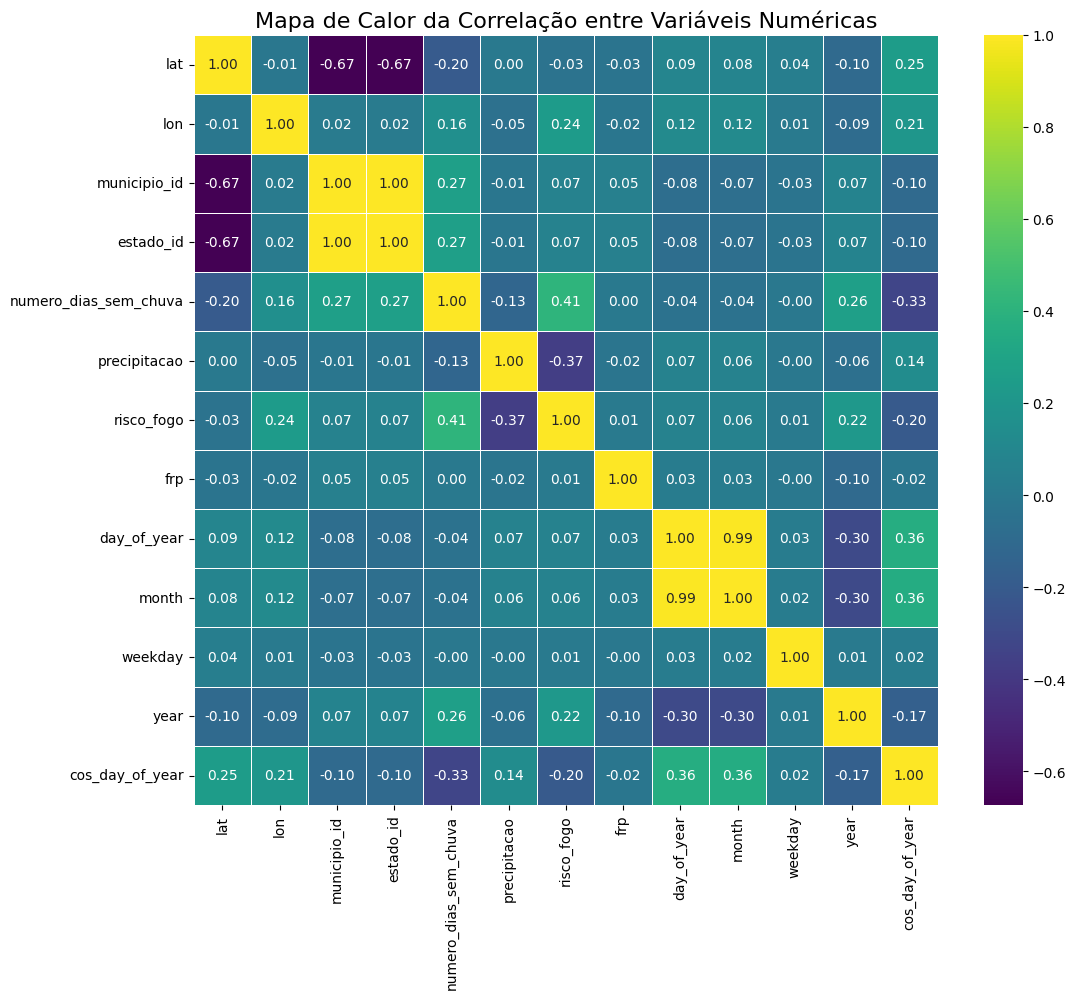

In [24]:
# Mapa de Calor da Correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Correlação entre Variáveis Numéricas', fontsize=16)
plt.show()

### Distribuição do risco de fogo por bioma (Boxplot)

<ipython-input-25-01897eccc689>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bioma', y='risco_fogo', data=df, palette='Set2')


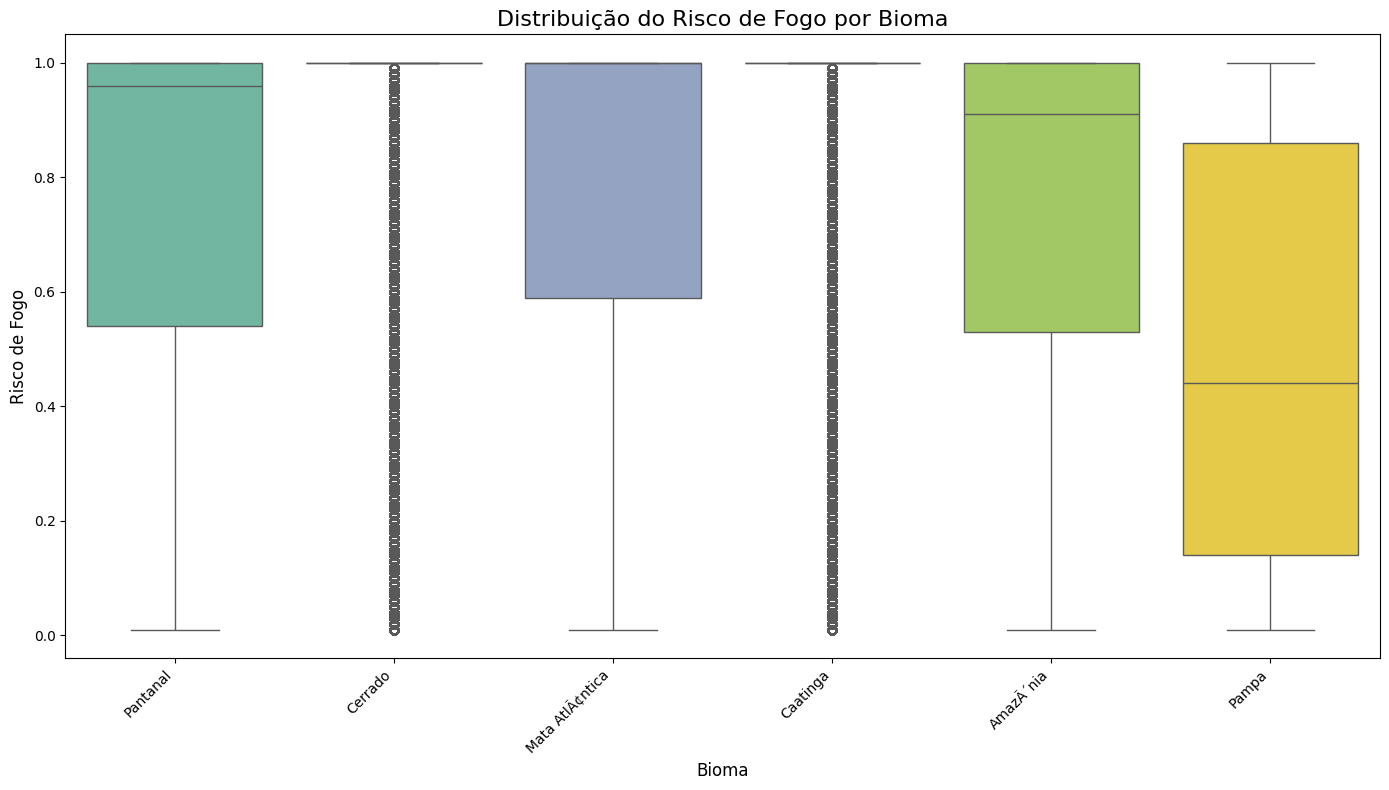

In [25]:
# Distribuição do risco de fogo por bioma (Boxplot)
plt.figure(figsize=(14, 8))
sns.boxplot(x='bioma', y='risco_fogo', data=df, palette='Set2')
plt.title('Distribuição do Risco de Fogo por Bioma', fontsize=16)
plt.xlabel('Bioma', fontsize=12)
plt.ylabel('Risco de Fogo', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Distribuição do risco de fogo por estado (Boxplot)

<ipython-input-26-ea2c36336f9d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='estado', y='risco_fogo', data=df, palette='tab10')
<ipython-input-26-ea2c36336f9d>:9: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-ea2c36336f9d>:9: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-ea2c36336f9d>:9: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-ea2c36336f9d>:9: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pyl

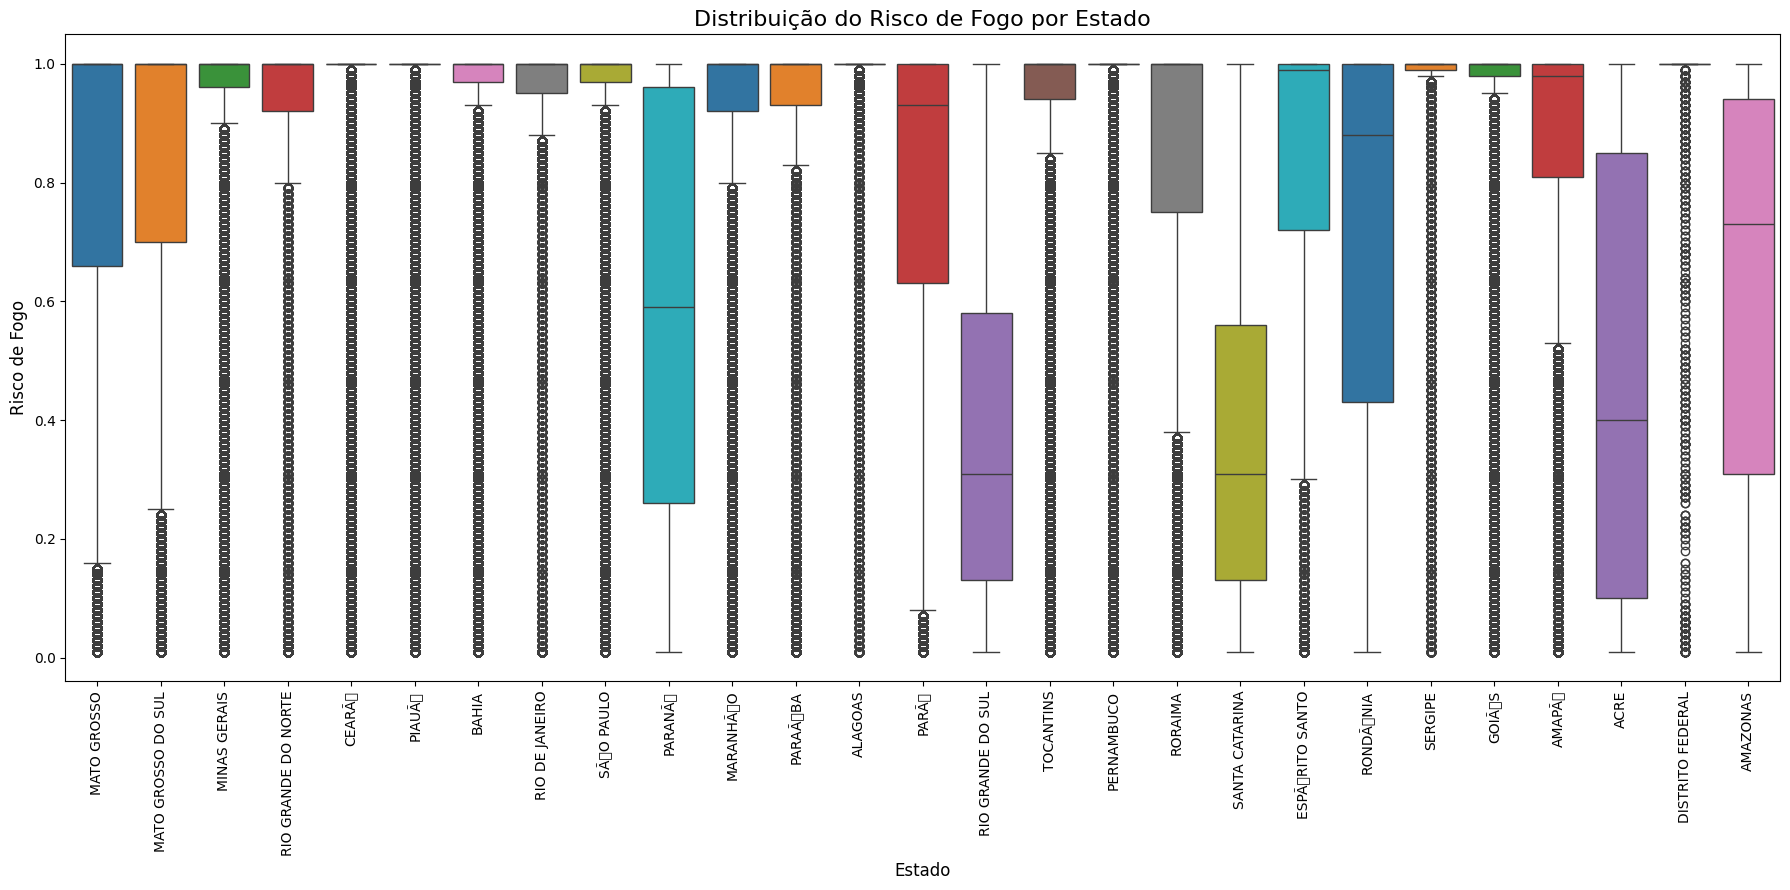

In [26]:
# Distribuição do risco de fogo por estado (Boxplot)
plt.figure(figsize=(18, 9))
sns.boxplot(x='estado', y='risco_fogo', data=df, palette='tab10')
plt.title('Distribuição do Risco de Fogo por Estado', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Risco de Fogo', fontsize=12)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Distribuição de Focos por Bioma (Contagem)

<ipython-input-27-ec3f519bba08>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bioma', data=df, order=df['bioma'].value_counts().index, palette='coolwarm')


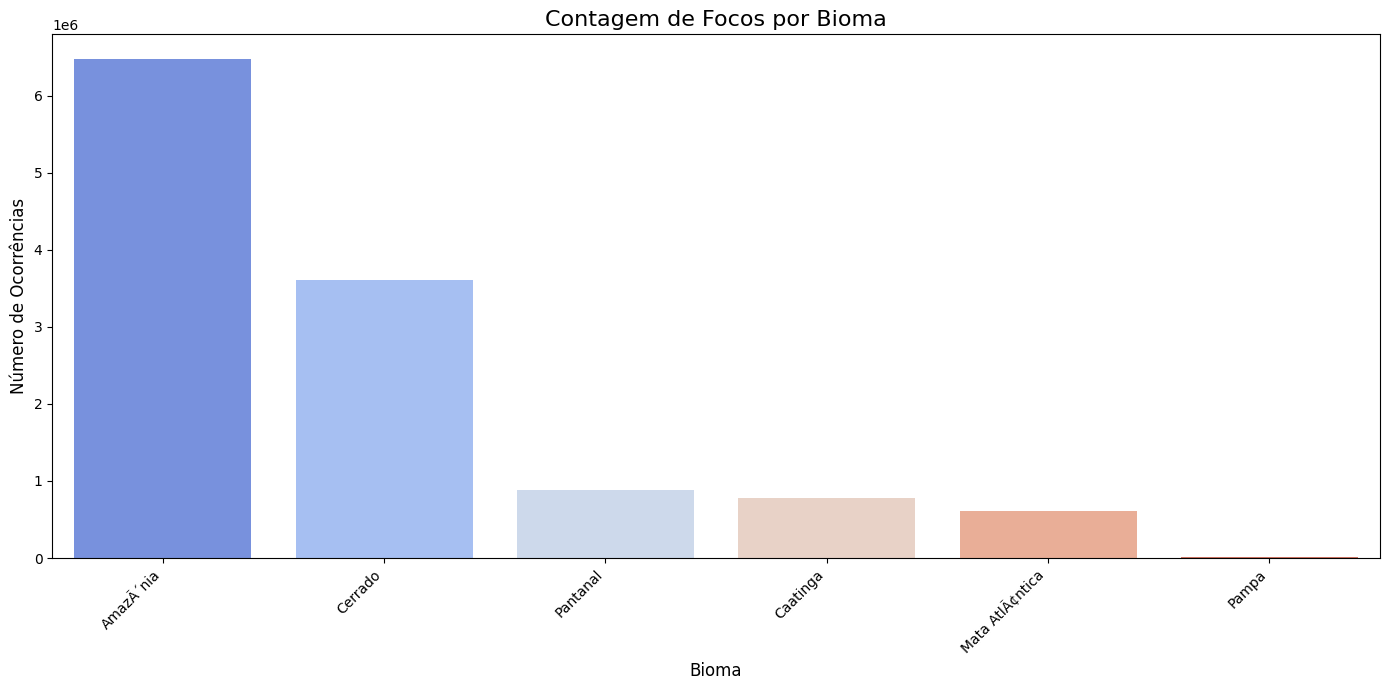

In [27]:
# Distribuição de Focos por Bioma (Contagem)
plt.figure(figsize=(14, 7))
sns.countplot(x='bioma', data=df, order=df['bioma'].value_counts().index, palette='coolwarm')
plt.title('Contagem de Focos por Bioma', fontsize=16)
plt.xlabel('Bioma', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Distribuição de Focos por Estado (Contagem)

<ipython-input-28-46059dac34a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='estado', data=df, order=df['estado'].value_counts().index, palette='viridis')
<ipython-input-28-46059dac34a2>:9: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-46059dac34a2>:9: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-46059dac34a2>:9: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-46059dac34a2>:9: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/d

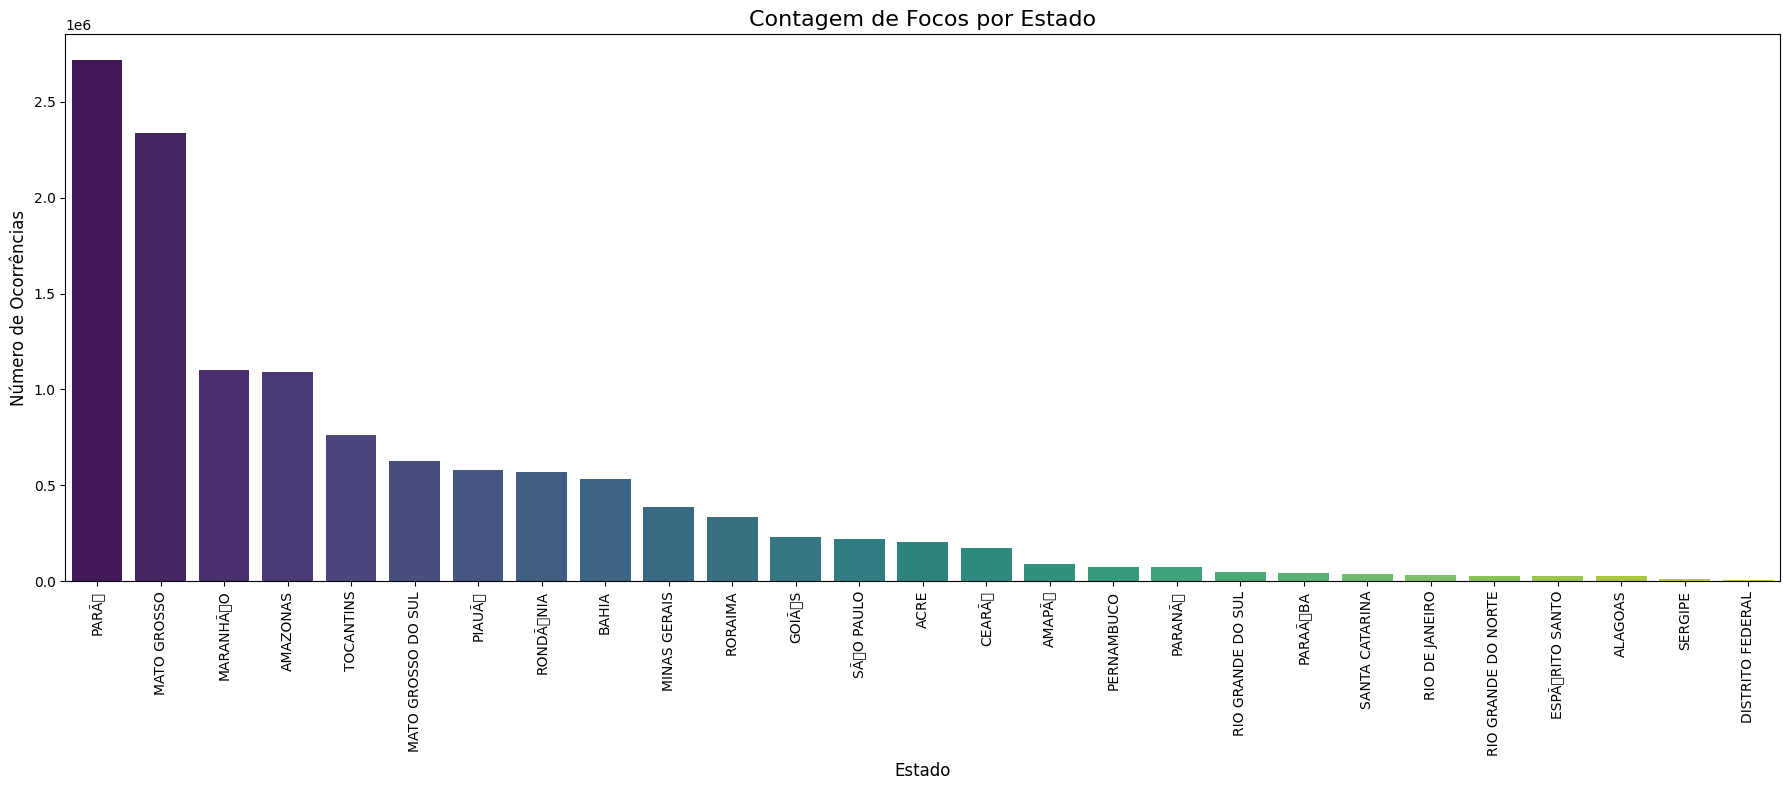

In [28]:
# Distribuição de Focos por Estado (Contagem)
plt.figure(figsize=(18, 8))
sns.countplot(x='estado', data=df, order=df['estado'].value_counts().index, palette='viridis')
plt.title('Contagem de Focos por Estado', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Análise da Série Temporal de Focos de Incêndio (Mensal)

<ipython-input-28-66db44c37634>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_focos = df.set_index('date')['risco_fogo'].resample('M').sum()


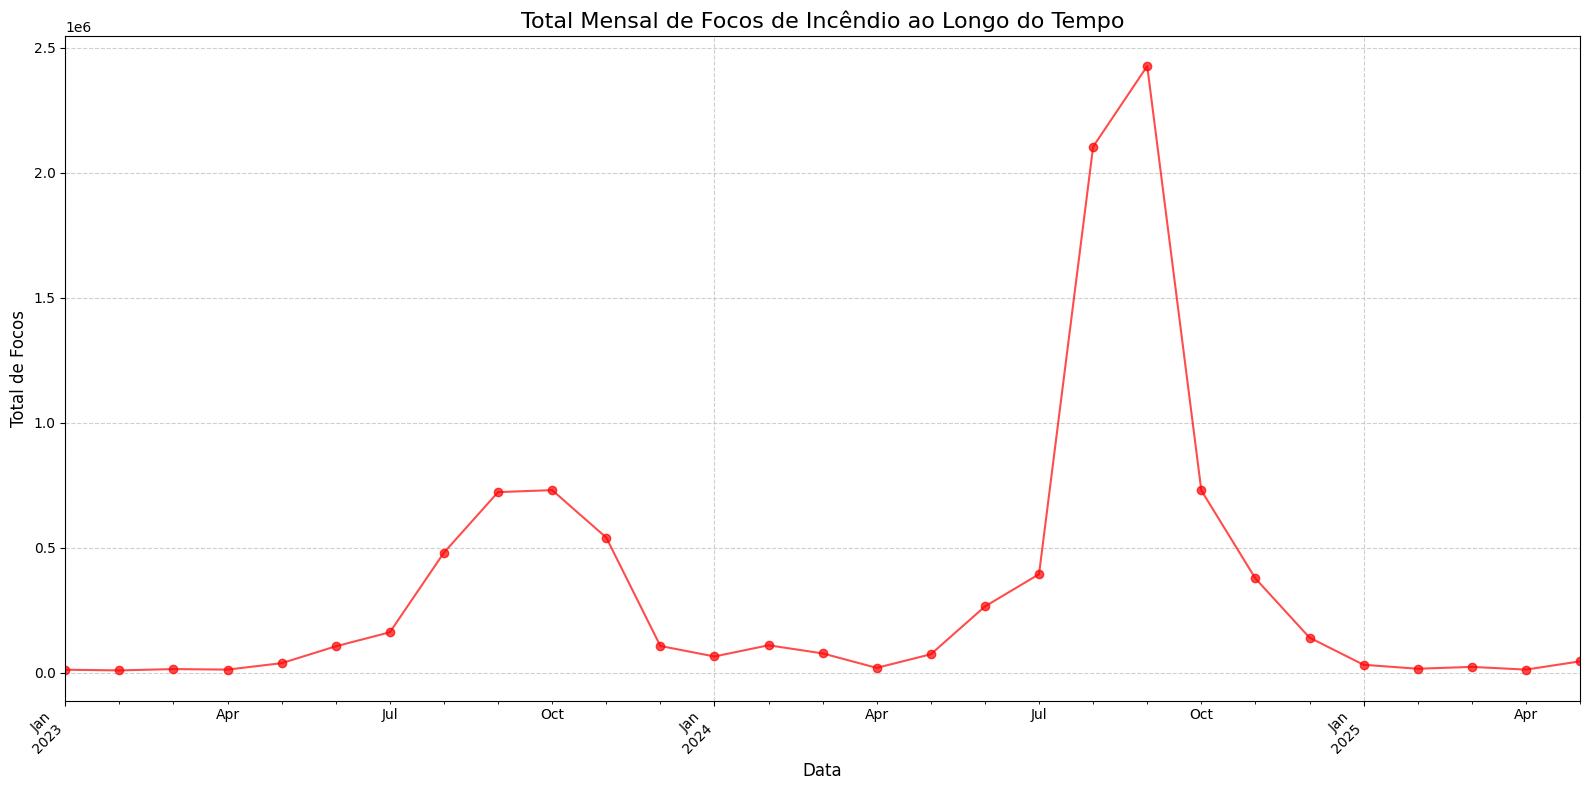

In [28]:
# Análise da Série Temporal de Focos de Incêndio (Mensal)
# Agrupar por mês e somar o número de focos
monthly_focos = df.set_index('date')['risco_fogo'].resample('M').sum()

plt.figure(figsize=(16, 8))
monthly_focos.plot(marker='o', linestyle='-', color='red', alpha=0.7)
plt.title('Total Mensal de Focos de Incêndio ao Longo do Tempo', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Total de Focos', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## Distribuição das novas features de tempo

<ipython-input-29-e9a66d8300d1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=df, palette='pastel')
<ipython-input-29-e9a66d8300d1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weekday', data=df, palette='muted')


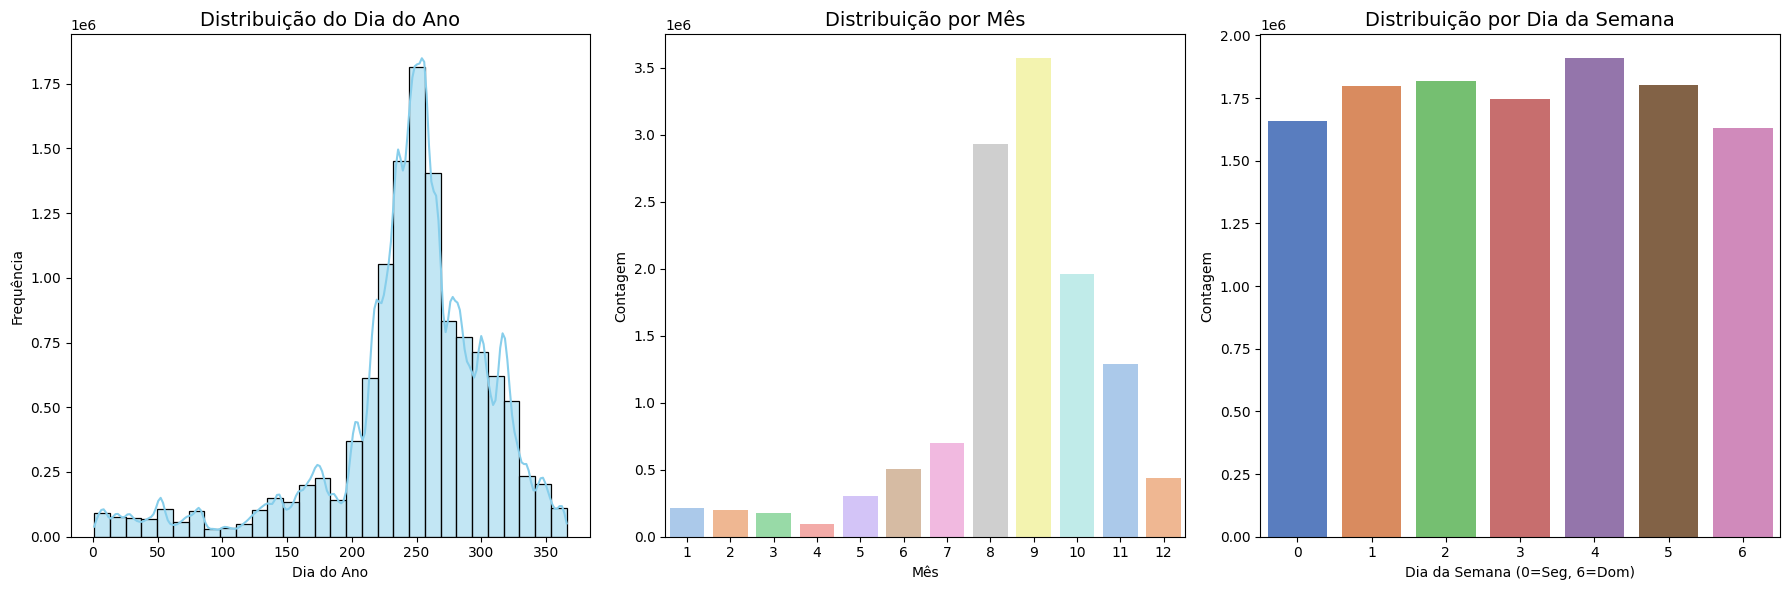

In [29]:
# Distribuição das novas features de tempo
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df['day_of_year'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição do Dia do Ano', fontsize=14)
plt.xlabel('Dia do Ano', fontsize=10)
plt.ylabel('Frequência', fontsize=10)

plt.subplot(1, 3, 2)
sns.countplot(x='month', data=df, palette='pastel')
plt.title('Distribuição por Mês', fontsize=14)
plt.xlabel('Mês', fontsize=10)
plt.ylabel('Contagem', fontsize=10)

plt.subplot(1, 3, 3)
sns.countplot(x='weekday', data=df, palette='muted')
plt.title('Distribuição por Dia da Semana', fontsize=14)
plt.xlabel('Dia da Semana (0=Seg, 6=Dom)', fontsize=10)
plt.ylabel('Contagem', fontsize=10)

plt.tight_layout()
plt.show()